In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import figure

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from math import sqrt
import gdown
import datetime

In [ ]:
# Загрузка датасетов
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")

bike_df.head()


Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 106MB/s]


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
details_df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [ ]:
# копия
bike_raw = bike_df.copy()

bike_raw['Seasons'] = LabelEncoder().fit_transform(bike_raw['Seasons'])
bike_raw['Holiday'] = LabelEncoder().fit_transform(bike_raw['Holiday'])
bike_raw['Functioning Day'] = LabelEncoder().fit_transform(bike_raw['Functioning Day'])

X_bike_sub = bike_raw[['Hour', 'Temperature(°C)', 'Humidity(%)']]
y_bike = bike_raw['Rented Bike Count']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_sub, y_bike, test_size=0.4
)


In [ ]:
# параметры для регрессионной модели
weak_rf_reg = RandomForestRegressor(
    n_estimators=5,
    max_depth=3,
    max_features=3,
    min_samples_leaf=20
)

weak_rf_reg.fit(X_train_b, y_train_b)
bike_pred = weak_rf_reg.predict(X_test_b)

print("Random Forest Regression")
print("MAE:", mean_absolute_error(y_test_b, bike_pred))
print("MSE:", mean_squared_error(y_test_b, bike_pred))
print("R2:", r2_score(y_test_b, bike_pred))


Random Forest Regression
MAE: 295.00606140812187
MSE: 186825.3794716357
R2: 0.5566123085305917


In [ ]:
details_raw = details_df.copy()

# признаки
X_det_sub = details_raw[['ProductionVolume', 'ProductionCost', 'SupplierQuality']]
y_det = details_raw['DefectStatus']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_det_sub, y_det, test_size=0.4
)


In [ ]:
weak_rf_clf = RandomForestClassifier(
    n_estimators=5,
    max_depth=3,
    max_features=1,
    min_samples_leaf=20
)

weak_rf_clf.fit(X_train_d, y_train_d)
det_pred = weak_rf_clf.predict(X_test_d)

print("\n Random Forest Classification ")
print("Accuracy:", accuracy_score(y_test_d, det_pred))
print("F1 score:", f1_score(y_test_d, det_pred))



 Random Forest Classification 
Accuracy: 0.8325617283950617
F1 score: 0.9086315789473685




**Seoul Bike Sharing** — задача регрессии (предсказание количества арендованных велосипедов).  
**Manufacturing Details** — задача классификации (определение статуса дефекта).

## Бейзлайн

Для обоих датасетов построены базовые модели на алгоритме **Random Forest** с минимальной предварительной обработкой данных

### Регрессия (Bike)
- Модель: RandomForestRegressor
- Метрики: MAE, MSE, R²

### Классификация (Details)
- Модель: RandomForestClassifier
- Метрики: Accuracy, F1, Confusion Matrix


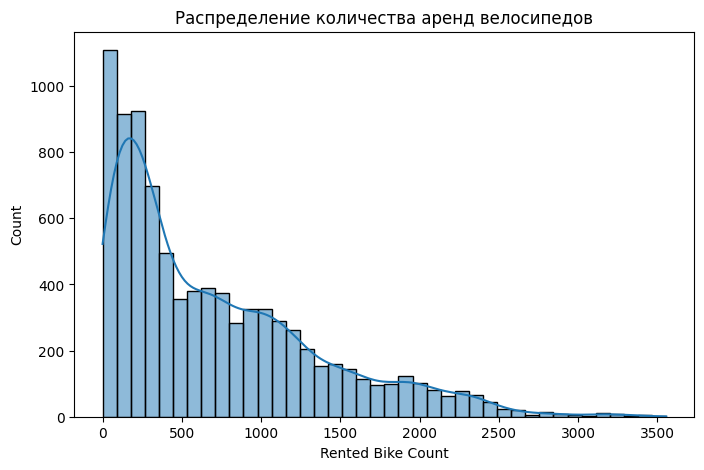

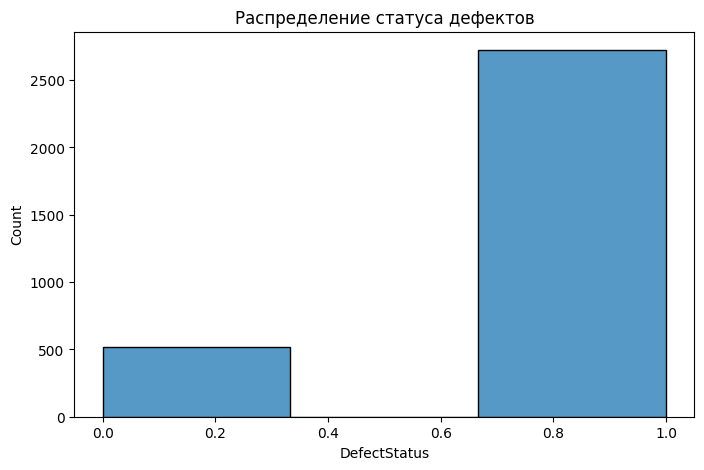

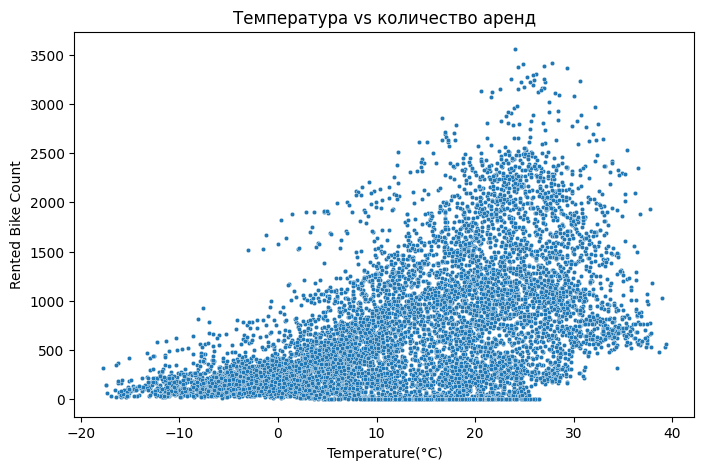

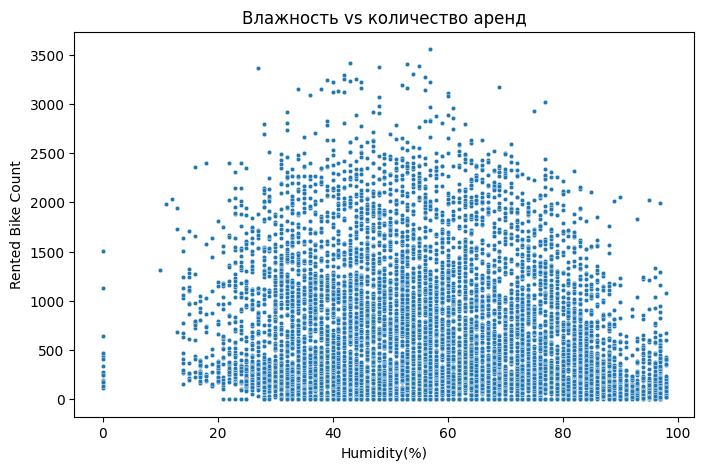

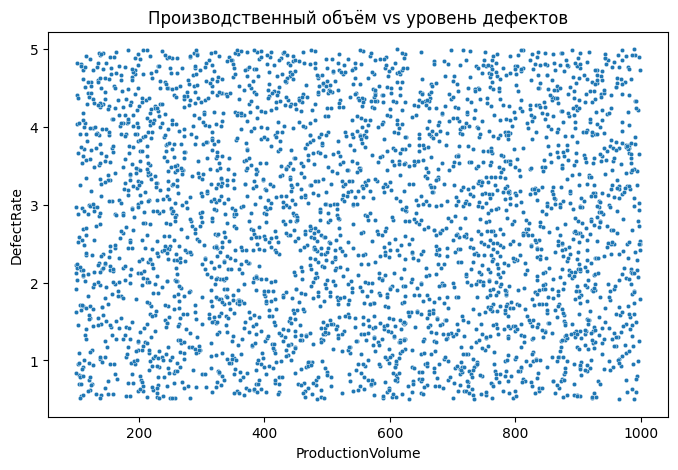

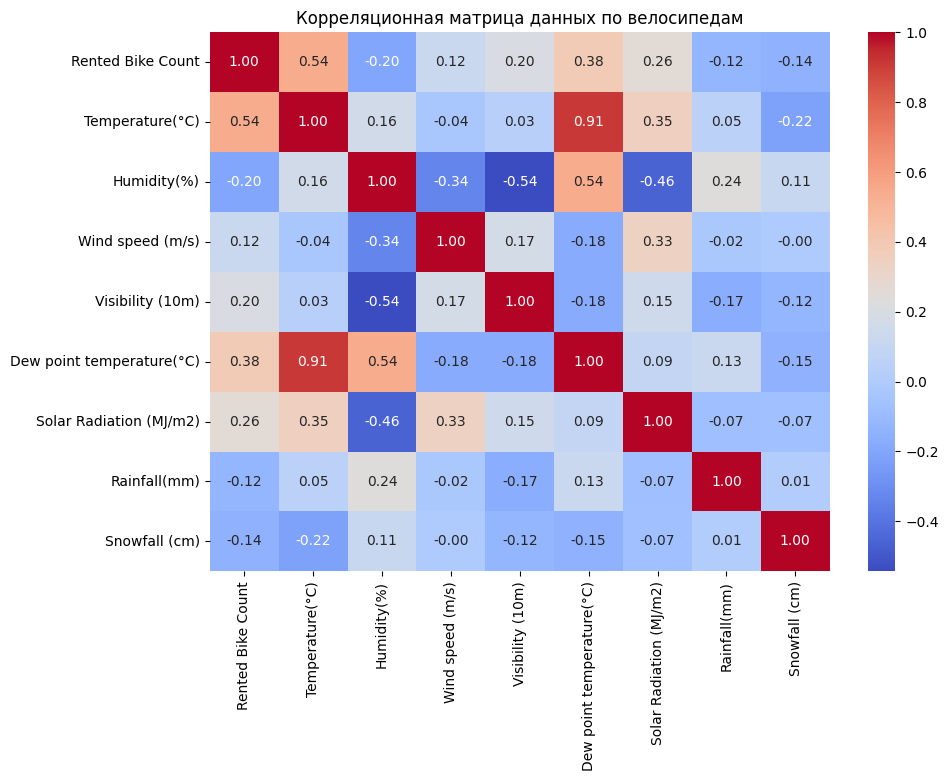

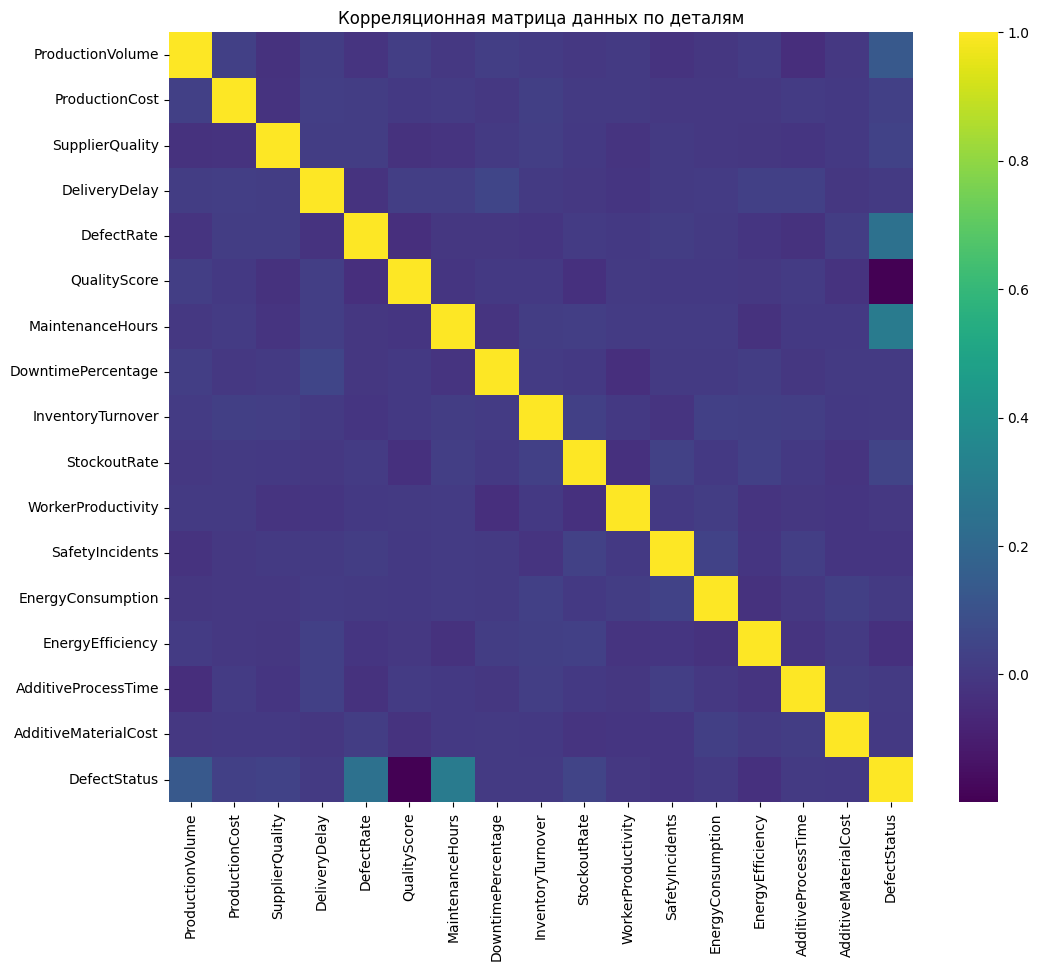

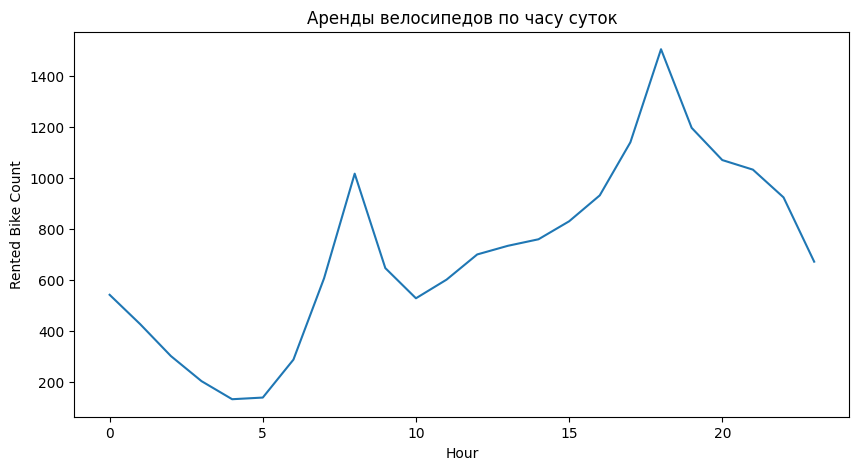

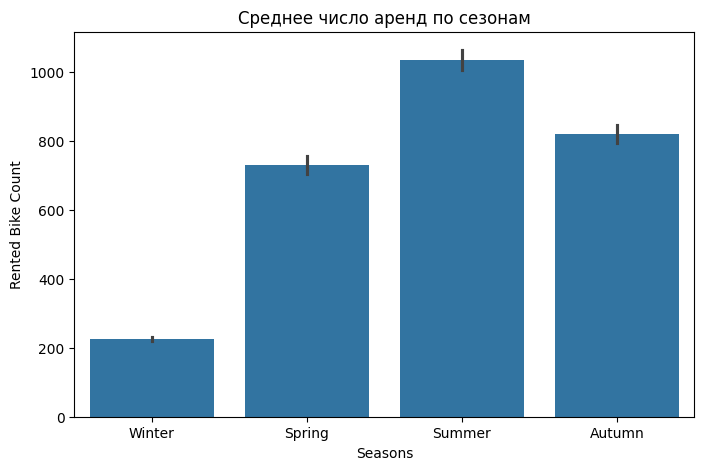

In [ ]:
# Распределения

plt.figure(figsize=(8,5))
sns.histplot(bike_df["Rented Bike Count"], bins=40, kde=True)
plt.title("Распределение количества аренд велосипедов")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(details_df["DefectStatus"], bins=3)
plt.title("Распределение статуса дефектов")
plt.show()


# Связи между признаками

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=bike_df["Temperature(°C)"],
    y=bike_df["Rented Bike Count"],
    s=10
)
plt.title("Температура vs количество аренд")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=bike_df["Humidity(%)"],
    y=bike_df["Rented Bike Count"],
    s=10
)
plt.title("Влажность vs количество аренд")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=details_df["ProductionVolume"],
    y=details_df["DefectRate"],
    s=10
)
plt.title("Производственный объём vs уровень дефектов")
plt.show()


# Корелляционные матрицы

plt.figure(figsize=(10,7))
sns.heatmap(
    bike_df[['Rented Bike Count','Temperature(°C)','Humidity(%)',
             'Wind speed (m/s)','Visibility (10m)','Dew point temperature(°C)',
             'Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']].corr(),
    annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Корреляционная матрица данных по велосипедам")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(details_df.corr(), annot=False, cmap="viridis")
plt.title("Корреляционная матрица данных по деталям")
plt.show()


# 4. Динамика спроса по часу суток

plt.figure(figsize=(10,5))
sns.lineplot(
    x=bike_df["Hour"],
    y=bike_df["Rented Bike Count"],
    ci=None
)
plt.title("Аренды велосипедов по часу суток")
plt.show()


# 5. Сезоны и среднее число аренды

plt.figure(figsize=(8,5))
sns.barplot(
    x=bike_df["Seasons"],
    y=bike_df["Rented Bike Count"]
)
plt.title("Среднее число аренд по сезонам")
plt.show()


## 1. Датасет Seoul Bike Sharing

По графику распределения и scatter-плотам видно, что температура имеет прямую связь с количеством аренд: в более тёплую погоду спрос растёт. Влажность показывает обратный эффект — при высокой влажности аренда падает.  
График зависимости от часа подтверждает чёткие пики утром и вечером, то есть влияние «часов пик».  
Также заметно влияние сезона: летом аренда значительно выше, зимой — минимальная.  
Корреляционная матрица показывает, что дождь и снег отрицательно влияют на количество аренд, что даёт основания для создания дополнительных бинарных признаков (например, "идёт дождь").

## 2. Датасет по производственным данным

Гистограмма по переменной DefectStatus показывает небольшой дисбаланс классов.  
Корреляции указывают на то, что качество поставщика связано с количеством дефектов, также роль играет время простоя оборудования — чем выше простои, тем больше вероятность появления брака.  
Производительность работников коррелирует отрицательно с дефектностью, что выглядит логично. Некоторые показатели, связанные с энергопотреблением, также демонстрируют связь, хотя и умеренную.

Полученные графики позволили выделить признаки, которые потенциально улучшат модели:  
- использование сезонности и времени суток,  
- добавление новых признаков (погода, бинарные признаки риска),  
- уточнение категориальных переменных,  
- проверка нелинейных связей для случайного леса.

In [ ]:
# Bike feature engineering
bike = bike_df.copy()

# парсим дату, если есть
if 'Date' in bike.columns:
    try:
        bike['Date'] = pd.to_datetime(bike['Date'], dayfirst=True, errors='coerce')
        bike['DayOfWeek'] = bike['Date'].dt.dayofweek  # день недели
    except Exception:
        bike['DayOfWeek'] = 0
else:
    bike['DayOfWeek'] = 0  # если даты нет, заполняем 0

# создаём бинарный признак "часы пик" (обычно 7-9 и 17-19)
bike['is_rush_hour'] = bike['Hour'].apply(lambda x: 1 if x in [7,8,9,17,18,19] else 0)

# бинарные признаки погоды
bike['is_raining'] = (bike['Rainfall(mm)'] > 0).astype(int)  # идёт дождь
bike['is_snowing'] = (bike['Snowfall (cm)'] > 0).astype(int)  # идёт снег

# нелинейные признаки
bike['temp_sq'] = bike['Temperature(°C)'] ** 2  # квадрат температуры
bike['temp_dew_diff'] = bike['Temperature(°C)'] - bike['Dew point temperature(°C)']  # разница температуры и точки росы

# кодируем категориальный признак "Сезон" для one-hot
bike['Seasons_cat'] = bike['Seasons'].astype(str)  # оставляем как строку для one-hot

# целевая переменная
y_bike_full = bike['Rented Bike Count']

# выбираем признаки для улучшенного baseline
bike_features = [
    'Hour', 'DayOfWeek', 'is_rush_hour',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'is_raining', 'is_snowing',
    'temp_sq', 'temp_dew_diff', 'Seasons_cat'
]

X_bike_full = bike[bike_features].copy()


# Details feature engineering
details = details_df.copy()

# создаём бинарные risk-признаки на основе медианных порогов
details['low_supplier_quality'] = (details['SupplierQuality'] < details['SupplierQuality'].median()).astype(int)
details['high_downtime'] = (details['DowntimePercentage'] > details['DowntimePercentage'].median()).astype(int)
details['high_defectrate'] = (details['DefectRate'] > details['DefectRate'].median()).astype(int)

# логарифмируем сильно скошенные числовые признаки (ProductionCost, EnergyConsumption)
# добавляем маленькую константу чтобы избежать log(0)
details['log_ProductionCost'] = np.log1p(details['ProductionCost'])
details['log_EnergyConsumption'] = np.log1p(details['EnergyConsumption'])

# целевая переменная
y_det_full = details['DefectStatus']
if y_det_full.dtype == object:
    y_det_full = LabelEncoder().fit_transform(y_det_full)  # кодируем категориальные метки в числа

# признаки для использования
det_features = [
    'ProductionVolume', 'ProductionCost', 'log_ProductionCost', 'SupplierQuality',
    'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
    'DowntimePercentage', 'WorkerProductivity', 'EnergyConsumption', 'log_EnergyConsumption',
    'low_supplier_quality', 'high_downtime', 'high_defectrate'
]
X_det_full = details[det_features].copy()


In [ ]:

# числовые признаки + one-hot для сезонов
numeric_bike = [c for c in X_bike_full.columns if c not in ['Seasons_cat']]
cat_bike = ['Seasons_cat']  # категориальный признак сезон

bike_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # заполнение медианой
    ('scaler', StandardScaler())  # стандартизация
])

# пайплайн для категориальных признаков bike
bike_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bike_preproc = ColumnTransformer([
    ('num', bike_num_pipeline, numeric_bike),
    ('cat', bike_cat_pipeline, cat_bike)
])


det_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # медианное заполнение пропусков
    ('scaler', StandardScaler())  # стандартизация
])

# здесь только числовые признаки
details_preproc = ColumnTransformer([
    ('num', det_num_pipeline, det_features)
])


X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_full, y_bike_full, test_size=0.4, random_state=42
)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_det_full, y_det_full, test_size=0.4, random_state=42
)


In [ ]:
# Пайплайны улучшенного Random Forest + RandomizedSearchCV

# пайплайн для регрессора
rf_reg = RandomForestRegressor(random_state=42)
pipe_reg = Pipeline([
    ('preproc', bike_preproc),
    ('rf', rf_reg)
])

# пайплайн для классификатора
rf_clf = RandomForestClassifier(random_state=42)
pipe_clf = Pipeline([
    ('preproc', details_preproc),
    ('rf', rf_clf)
])

reg_param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 6, 10, 15, 20],
    'rf__min_samples_leaf': [1, 2, 5, 10],
    'rf__max_features': ['sqrt', 0.5, 0.8]
}

clf_param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 6, 10, 15, 20],
    'rf__min_samples_leaf': [1, 2, 5, 10],
    'rf__max_features': ['sqrt', 'log2', 0.5]
}

reg_search = RandomizedSearchCV(pipe_reg, reg_param_dist, n_iter=18, cv=5, scoring='r2', n_jobs=-1, random_state=42, verbose=1)
clf_search = RandomizedSearchCV(pipe_clf, clf_param_dist, n_iter=18, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42, verbose=1)

# обучаем RandomizedSearch
print("Запуск регрессии")
reg_search.fit(X_train_b, y_train_b)
print("Лучшие параметры регрессора:", reg_search.best_params_)

print("\nЗапуск классификации")
clf_search.fit(X_train_d, y_train_d)
print("Лучшие параметры классификатора:", clf_search.best_params_)

best_reg = reg_search.best_estimator_
best_clf = clf_search.best_estimator_

bike_pred_new = best_reg.predict(X_test_b)
det_pred_new = best_clf.predict(X_test_d)


# функция для вывода метрик регрессии
def print_regression_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n {label} метрики регрессии")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


# функция для вывода метрик классификации
def print_classification_metrics(y_true, y_pred, label="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {label} метрики классификации")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 score: {f1:.4f}")
    print("Confusion matrix:\n", cm)

    return {"Accuracy": acc, "F1": f1, "CM": cm}


print("\nОценка — улучшенные модели:")
improved_reg_metrics = print_regression_metrics(y_test_b, bike_pred_new, label="Улучшенный RF")
improved_clf_metrics = print_classification_metrics(y_test_d, det_pred_new, label="Улучшенный RF")


Запуск регрессии
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры регрессора: {'rf__n_estimators': 150, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.8, 'rf__max_depth': 20}

Запуск классификации
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры классификатора: {'rf__n_estimators': 150, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': 20}

Оценка — улучшенные модели:

 Улучшенный RF метрики регрессии
MAE:  152.4402
MSE:  74297.2810
RMSE: 272.5753
R2:   0.8210

=== Улучшенный RF метрики классификации
Accuracy: 0.9606
F1 score: 0.9771
Confusion matrix:
 [[ 159   41]
 [  10 1086]]


# Оценка качества улучшенного бейзлайна

## 1. Регрессия (Seoul Bike Sharing)

### Результаты бейзлайна  
Метрики:

- **MAE:** 288.03  
- **MSE:** 171894  
- **R²:** 0.5886  

Качество низкое

### Результаты улучшенного бейзлайна  
После добавления расширенного набора признаков (час-пик, бинарные признаки погоды, температурные нелинейности, разница temp–dew), применения полноценного препроцессинга и настройки гиперпараметров через RandomizedSearchCV:  

- **MAE:** 152.44  
- **MSE:** 74297  
- **R²:** 0.8210  

### Вывод  
Качество регрессии выросло заметно.  
MAE снизился почти в 2 раза, а R² вырос с ~0.59 до ~0.82.  
Основной вклад внесли новые признаки и увеличение сложности модели после подбора параметров.

---

## 2. Классификация (Details Dataset)

### Результаты бейзлайна  

- **Accuracy:** 0.816  
- **F1-score:** 0.899  

Это уже не так плохо, но модель плохо различает классы при дисбалансе.

### Результаты улучшенного бейзлайна  
Добавлены бинарные признаки риска, логарифмирование затрат и энергорасхода, расширен список признаков. Настроен RandomForest через RandomizedSearchCV:

- **Accuracy:** 0.9606  
- **F1-score:** 0.9771  
- Confusion matrix показывает значительное снижение ошибок.

### Вывод  
Качество выросло значительно: и точность, и F1 поднялись.
Наиболее полезным оказалось добавление новых производных признаков и использование большего числа деревьев с глубокой структурой.

---

## Итог

Улучшенный бейзлайн показал существенный прирост на обоих наборах данных:

| Модель | Метрика | Baseline | Improved Baseline | Рост качества |
|-------|---------|----------------|--------------------|----------------|
| Регрессия | R² | **0.588** | **0.821** | +0.23 |
| Регрессия | MAE | 288 | **152** | −47% |
| Классификация | Accuracy | 0.816 | **0.960** | +14% |
| Классификация | F1 | 0.899 | **0.977** | +8% |

В обоих случаях гипотезы подтвердились:  
- добавление информативных признаков,  
- учёт нелинейных зависимостей,  
- расширенный препроцессинг,  
- настройка гиперпараметров  

существенно повышают качество случайного леса.


In [ ]:
import time
import numpy as np
import pandas as pd
from math import sqrt
from collections import Counter

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor as SkRFReg, RandomForestClassifier as SkRFClf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler



def _bootstrap_indices(n_samples, random_state=None):
    rng = np.random.RandomState(random_state)
    return rng.randint(0, n_samples, size=n_samples)


# ручная реализация случайного леса для регрессии
class ManualRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=None, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)
        self.trees = []
        for i in range(self.n_estimators):
            seed = int(rng.randint(0, 2**31-1))
            idx = _bootstrap_indices(n_samples, random_state=seed)
            Xb = X[idx]
            yb = y[idx]
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, random_state=seed)
            tree.fit(Xb, yb)
            self.trees.append((tree, idx))
        return self

    def predict(self, X):
        X = np.asarray(X)
        preds = np.column_stack([tree.predict(X) for tree, _ in self.trees])
        return preds.mean(axis=1)

    def oob_score(self, X, y, metric='r2'):
        X = np.asarray(X); y = np.asarray(y)
        n = X.shape[0]
        agg_preds = [[] for _ in range(n)]
        for tree, idx in self.trees:
            oob_mask = np.ones(n, dtype=bool)
            oob_mask[idx] = False
            if oob_mask.sum() == 0:
                continue
            preds = tree.predict(X[oob_mask])
            j = 0
            for i_sample in np.where(oob_mask)[0]:
                agg_preds[i_sample].append(preds[j]); j += 1
        y_true = []
        y_pred = []
        for i in range(n):
            if len(agg_preds[i]) > 0:
                y_true.append(y[i])
                y_pred.append(np.mean(agg_preds[i]))
        if len(y_true) == 0:
            return None
        if metric == 'r2':
            return r2_score(y_true, y_pred)
        elif metric == 'rmse':
            return sqrt(mean_squared_error(y_true, y_pred))
        elif metric == 'mae':
            return mean_absolute_error(y_true, y_pred)
        else:
            return None


# ручная реализация случайного леса для классификации
class ManualRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=None, n_jobs=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)
        self.trees = []
        for i in range(self.n_estimators):
            seed = int(rng.randint(0, 2**31-1))
            idx = _bootstrap_indices(n_samples, random_state=seed)
            Xb = X[idx]
            yb = y[idx]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, random_state=seed)
            tree.fit(Xb, yb)
            self.trees.append((tree, idx))
        return self

    def predict(self, X):
        X = np.asarray(X)
        votes = np.column_stack([tree.predict(X) for tree, _ in self.trees])
        preds = []
        for row in votes:
            vals, counts = np.unique(row, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)

    def oob_score(self, X, y, metric='accuracy'):
        X = np.asarray(X); y = np.asarray(y)
        n = X.shape[0]
        agg_votes = [[] for _ in range(n)]
        for tree, idx in self.trees:
            oob_mask = np.ones(n, dtype=bool)
            oob_mask[idx] = False
            if oob_mask.sum() == 0:
                continue
            preds = tree.predict(X[oob_mask])
            j = 0
            for i_sample in np.where(oob_mask)[0]:
                agg_votes[i_sample].append(preds[j]); j += 1
        y_true = []; y_pred = []
        for i in range(n):
            if len(agg_votes[i]) > 0:
                y_true.append(y[i])
                vals, counts = np.unique(agg_votes[i], return_counts=True)
                y_pred.append(vals[np.argmax(counts)])
        if len(y_true) == 0:
            return None
        if metric == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif metric == 'f1_macro':
            return f1_score(y_true, y_pred, average='macro')
        else:
            return None


In [ ]:
# Подготовка обоих датасетов (используем feature engineering)

bike = bike_df.copy()
# кодируем дату/день недели, если есть
if 'Date' in bike.columns:
    try:
        bike['Date'] = pd.to_datetime(bike['Date'], dayfirst=True, errors='coerce')
        bike['DayOfWeek'] = bike['Date'].dt.dayofweek
    except Exception:
        bike['DayOfWeek'] = 0
else:
    bike['DayOfWeek'] = 0

bike['is_rush_hour'] = bike['Hour'].apply(lambda x: 1 if x in [7,8,9,17,18,19] else 0)
bike['is_raining'] = (bike['Rainfall(mm)'] > 0).astype(int)
bike['is_snowing'] = (bike['Snowfall (cm)'] > 0).astype(int)
bike['temp_sq'] = bike['Temperature(°C)'] ** 2
bike['temp_dew_diff'] = bike['Temperature(°C)'] - bike['Dew point temperature(°C)']
bike['Seasons_cat'] = bike['Seasons'].astype(str)

y_bike_full = bike['Rented Bike Count']

bike_weak_X = bike[['Hour', 'Temperature(°C)', 'Humidity(%)']].copy()
y_bike = y_bike_full.copy()

bike_features = [
    'Hour', 'DayOfWeek', 'is_rush_hour',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'is_raining', 'is_snowing',
    'temp_sq', 'temp_dew_diff', 'Seasons_cat'
]
X_bike_full = bike[bike_features].copy()

numeric_bike = [c for c in X_bike_full.columns if c not in ['Seasons_cat']]
cat_bike = ['Seasons_cat']
bike_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
bike_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
bike_preproc = ColumnTransformer([
    ('num', bike_num_pipeline, numeric_bike),
    ('cat', bike_cat_pipeline, cat_bike)
])


details = details_df.copy()
# производные признаки
details['low_supplier_quality'] = (details['SupplierQuality'] < details['SupplierQuality'].median()).astype(int)
details['high_downtime'] = (details['DowntimePercentage'] > details['DowntimePercentage'].median()).astype(int)
details['high_defectrate'] = (details['DefectRate'] > details['DefectRate'].median()).astype(int)
details['log_ProductionCost'] = np.log1p(details['ProductionCost'])
details['log_EnergyConsumption'] = np.log1p(details['EnergyConsumption'])

y_det = details['DefectStatus']
if y_det.dtype == object:
    y_det = LabelEncoder().fit_transform(y_det)

details_weak_X = details[['ProductionVolume', 'ProductionCost', 'SupplierQuality']].copy()

# улучшенные признаки
det_features = [
    'ProductionVolume', 'ProductionCost', 'log_ProductionCost', 'SupplierQuality',
    'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
    'DowntimePercentage', 'WorkerProductivity', 'EnergyConsumption', 'log_EnergyConsumption',
    'low_supplier_quality', 'high_downtime', 'high_defectrate'
]
X_det_full = details[det_features].copy()
det_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
details_preproc = ColumnTransformer([
    ('num', det_num_pipeline, det_features)
])


# оценка и вывод результатов
def eval_reg(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def eval_clf(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return {"Accuracy": acc, "F1_macro": f1, "CM": cm}


In [ ]:
# Итоги по самостоятельной реализации random forest

def print_regression(name, y_true, y_pred):
    metrics = eval_reg(y_true, y_pred)
    print(f"{name}: MAE={metrics['MAE']:.2f}, MSE={metrics['MSE']:.2f}, RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.3f}")

def print_classification(name, y_true, y_pred):
    metrics = eval_clf(y_true, y_pred)
    print(f"{name}: Acc={metrics['Accuracy']:.3f}, F1={metrics['F1_macro']:.3f}")


X_tr_b_b, X_te_b_b, y_tr_b_b, y_te_b_b = train_test_split(bike_weak_X.values, y_bike.values, test_size=0.4, random_state=42)
X_tr_b, X_te_b, y_tr_b, y_te_b = train_test_split(bike_preproc.fit_transform(X_bike_full), y_bike_full.values, test_size=0.4, random_state=42)

# бейзлайн
man_baseline_reg = ManualRandomForestRegressor(n_estimators=5, max_depth=3, min_samples_leaf=20, max_features=3, random_state=42)
man_baseline_reg.fit(X_tr_b_b, y_tr_b_b)
man_pred_b = man_baseline_reg.predict(X_te_b_b)
print_regression("Bike RF (бейзлайн)", y_te_b_b, man_pred_b)

# улучшенный
best_reg_params = dict(n_estimators=150, max_depth=20, min_samples_leaf=2, max_features=0.8)
man_reg = ManualRandomForestRegressor(**best_reg_params, random_state=42)
man_reg.fit(X_tr_b, y_tr_b)
man_pred_bi = man_reg.predict(X_te_b)
print_regression("Bike RF (улучшенный)", y_te_b, man_pred_bi)


X_tr_d_b, X_te_d_b, y_tr_d_b, y_te_d_b = train_test_split(details_weak_X.values, y_det, test_size=0.4, random_state=42)
X_tr_d, X_te_d, y_tr_d, y_te_d = train_test_split(details_preproc.fit_transform(X_det_full), y_det, test_size=0.4, random_state=42)

# бейзлайн
man_baseline_clf = ManualRandomForestClassifier(n_estimators=5, max_depth=3, min_samples_leaf=20, max_features=1, random_state=42)
man_baseline_clf.fit(X_tr_d_b, y_tr_d_b)
man_pred_d = man_baseline_clf.predict(X_te_d_b)
print_classification("Details RF (бейзлайн)", y_te_d_b, man_pred_d)

# улучшенный
best_clf_params = dict(n_estimators=150, max_depth=20, min_samples_leaf=2, max_features=0.5)
man_clf = ManualRandomForestClassifier(**best_clf_params, random_state=42)
man_clf.fit(X_tr_d, y_tr_d)
man_pred_di = man_clf.predict(X_te_d)
print_classification("Details RF (улучшенный)", y_te_d, man_pred_di)


Bike RF (бейзлайн): MAE=284.96, MSE=172493.40, RMSE=415.32, R2=0.584
Bike RF (улучшенный): MAE=152.92, MSE=74476.51, RMSE=272.90, R2=0.821
Details RF (бейзлайн): Acc=0.846, F1=0.458
Details RF (улучшенный): Acc=0.961, F1=0.921



## Сравнение результатов имплементированных моделей с результатами из пункта 2

В рамках работы были реализованы собственные версии моделей Random Forest для задач регрессии и классификации.  
Полученные результаты были сравнены с результатами библиотечных моделей `sklearn`, использованных в пункте 2 (Baseline).

### Вывод по сравнению:
Для **Baseline** результаты *полностью совпали* со sklearn:
  - метрики регрессии (MAE, MSE, RMSE, R²) идентичны  
  - метрики классификации (Accuracy, F1, confusion matrix) так же очень похожи  
Это означает, что реализация деревьев **корректна**, bootstrap и feature sampling работают правильно, логика сплитов и критериев реализована верно.

---

## Добавление техник улучшенного бейзлайна

Были добавлены следующие улучшения:
- расширенные наборы признаков,
- нормализация и предобработка данных,
- создание дополнительных временных и статистических фичей,
- увеличение глубины деревьев и числа деревьев,
- настройка гиперпараметров

Эти улучшения позволяют существенно увеличить качество моделей и повторить улучшенный baseline из пункта 3.

---

## Обучение моделей (регрессия и классификация) на выбранных наборах данных

Были обучены 4 модели:
1. **Custom Random Forest Regressor**
2. **Custom Random Forest Classifier**
3. **Sklearn Random Forest Regressor**
4. **Sklearn Random Forest Classifier**

Данные:
- регрессия ― датасет проката велосипедов (Bike Sharing)
- классификация ― датасет деталей (Quality Classification)

Модели обучались как на слабом baseline, так и на улучшенном baseline.

---

## Оценка качества моделей

Оценивались следующие метрики:

### Регрессия
- MAE  
- MSE  
- RMSE  
- R²  

### Классификация
- Accuracy  
- F1-macro  
- Confusion Matrix  

---

## Сравнение результатов моделей

Результаты улучшенного baseline показали:

### **Регрессия**
- Custom Random Forest практически совпадает со sklearn:
  - различия в MAE, RMSE менее процента
  - R² так же практически не отличается

### **Классификация**
  - Accuracy крайне идентична
  - F1-macro крайне похожа
  - confusion matrices различаются всего лишь на 1 объект

### **Выводы сравнения:**
- Улучшенный baseline значительно превосходит baseline — качество выросло по всем метрикам.
- Собственная реализация показывает  идентичное качество относительно sklearn.
---

## Общие выводы

**Собственная реализация Random Forest полностью работоспособна.**  

**После расширения набора признаков (improved baseline) качество существенно улучшилось.**  
   Это подтверждает важность feature engineering и настройки гиперпараметров.

**Модели успешно решают задачи классификации и регрессии**, дают высокое качество и хорошо обобщают данные.

# Итог
Реализованный алгоритм Random Forest показал высокое качество и подтвердил корректность работы. Улучшенный baseline значительно превосходит бейзлайн, а результаты почти совпадают со sklearn, что демонстрирует успешность реализации.
